# Lane Finding

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Read pickle data

import pickle
camera_calibration = pickle.load(open('./pickle_data/camera_calibration.p', 'rb'))
mtx = camera_calibration['mtx']
dist = camera_calibration['dist']

import pickle
perspective_transform = pickle.load(open('./pickle_data/perspective_transform.p', 'rb'))
M = perspective_transform['M']
Minv = perspective_transform['Minv']

In [3]:
# Adding methods from color and gradient threshold

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
  # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output


def combine(gray, gradx, grady, mag_binary, dir_binary):
    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1                           
    return combined


def warp_image(undist):
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped


def apply_all_processing(image):
    image = cv2.undistort(image, mtx, dist, None, mtx)
    HLS_image = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel_img = HLS_image[:,:,2]
    combined = np.zeros_like(s_channel_img)
    image = s_channel_img
    gradx = abs_sobel_thresh(image,  orient='x', thresh_min=10, thresh_max=160)
    grady = abs_sobel_thresh(image,  orient='y', thresh_min=10, thresh_max=160)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(10, 150))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 
    return combined

def transform_and_warp(image):
    return warp_image(apply_all_processing(image))

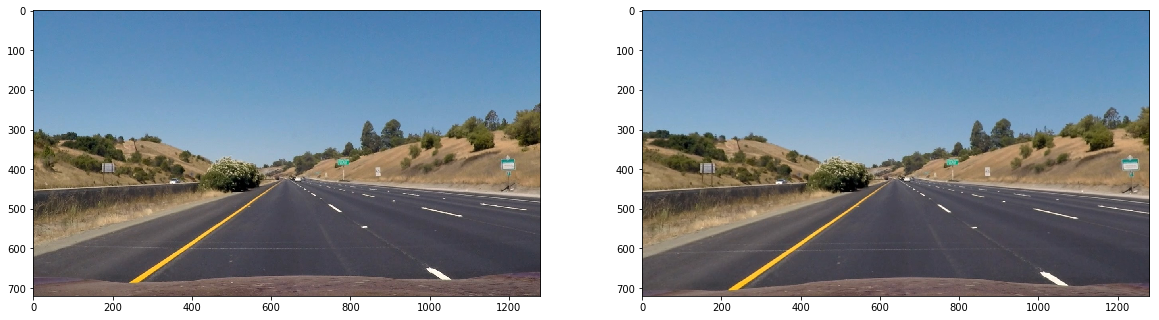

In [4]:
# Read and work the image
import os
image = mpimg.imread(os.path.join('./test_images', 'straight_lines1.jpg'))
undist = cv2.undistort(image, mtx, dist, None, mtx)

fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes = iter(axes)
next(axes).imshow(image)
next(axes).imshow(undist)

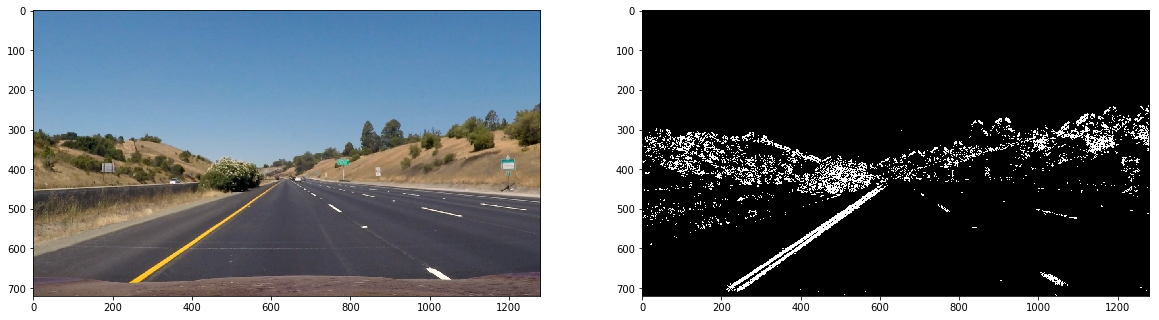

In [5]:
transformed_image = apply_all_processing(image)
fig, axes = plt.subplots(ncols=2, figsize=(20,10))
axes = iter(axes)
next(axes).imshow(image)
next(axes).imshow(transformed_image, cmap='gray')

(720, 1280)


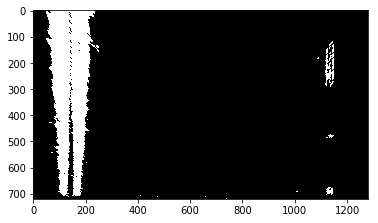

In [6]:
warppped_image = warp_image(transformed_image)
print(warppped_image.shape)
plt.imshow(warppped_image, cmap='gray')

# See all images

In [7]:
import os
file_names = sorted(os.listdir('./test_images'))

image_list = []
lane_image = []
for image_file_name in file_names:
    image_list.append(mpimg.imread(os.path.join('./test_images', image_file_name)))
    
for image in image_list:
    lane_image.append(transform_and_warp(image))
    


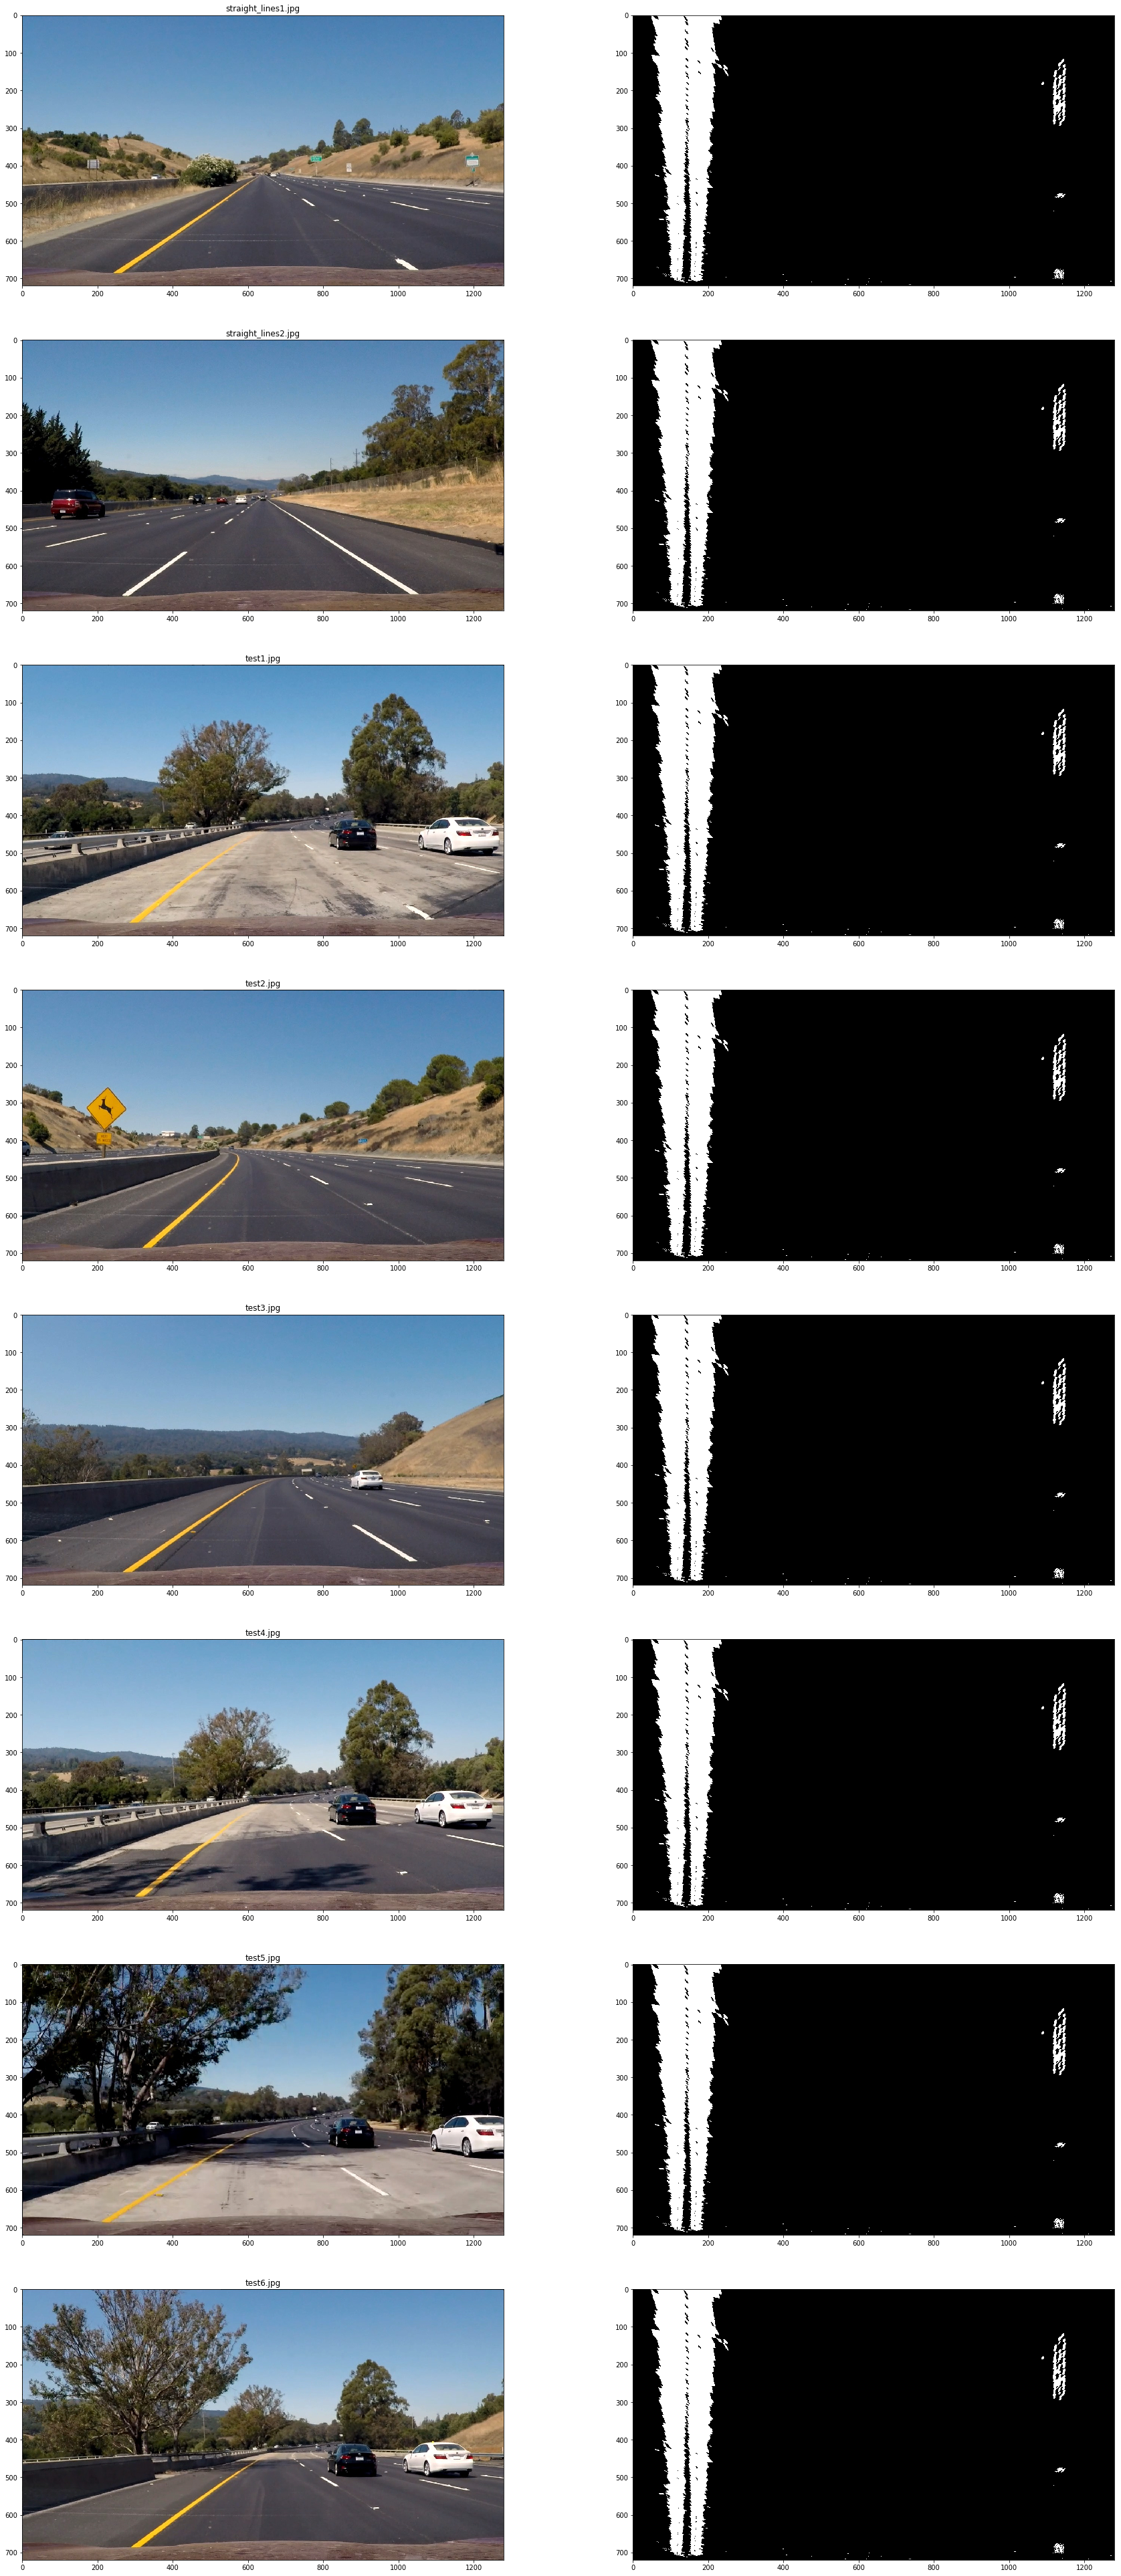

In [8]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(30, 70))
columns = 2
rows = len(image_list)
for i in range(rows):
    fig.add_subplot(rows, columns, 2*i+1)
    plt.title(file_names[i])
    plt.imshow(image_list[i])
    fig.add_subplot(rows, columns, 2*i+2)
    plt.imshow(lane_image[i], cmap='gray')
    
plt.show()

## Find lanes

In [9]:
binary_warped = lane_image[0]

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def FindLanes(binary_warped, visualize=False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit

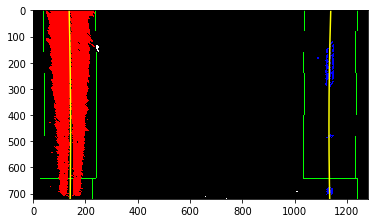

In [11]:
left_fit, right_fit = FindLanes(binary_warped, visualize=True)

### Skip the sliding windows step once you know where the lines are

In [12]:
def FindLanesUsingMargin(binary_warped, left_fit, right_fit, visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    if visualize:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    
    return left_fit, right_fit

### visualize

(array([-2.55691876e-05,  2.36406771e-02,  1.38049187e+02]),
 array([ 3.52114200e-05, -3.09456585e-02,  1.13804339e+03]))

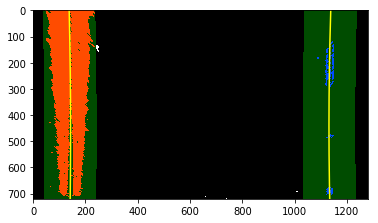

In [13]:
FindLanesUsingMargin(binary_warped, left_fit, right_fit, visualize=True)

## Measuring Curvature

In [14]:
def GetLanePoints(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

def GetCurveRadius(left_fitx, right_fitx, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension


    leftx = left_fitx
    rightx = right_fitx
    y_eval = max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad, 

## Project lanes back to original image

6422.86382452195 m 4664.062494735799 m


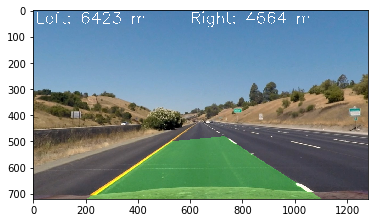

In [15]:
def ProjectLanesOnImage(undist, binary_warped, left_fitx, right_fitx, ploty):
    image = undist

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def AddLaneRadiusDetailsOnImage(image, left_fitx, right_fitx, ploty): 
    left_curverad, right_curverad = GetCurveRadius(left_fitx, right_fitx, ploty)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, 'Left: {:.0f} m'.format(left_curverad), (10,50), font, 2,(255,255,255),2)
    cv2.putText(image, 'Right: {:.0f} m'.format(right_curverad), (600,50), font, 2,(255,255,255),2)
    return image

left_fitx, right_fitx, ploty = GetLanePoints(left_fit, right_fit, binary_warped)
result = ProjectLanesOnImage(undist, binary_warped, left_fitx, right_fitx, ploty)
result = AddLaneRadiusDetailsOnImage(result, left_fitx, right_fitx, ploty)
plt.imshow(result)

## Identify car location

141.81540731795576
1134.0161122118625
640.0
637.9157597649091
0.011016698385480335


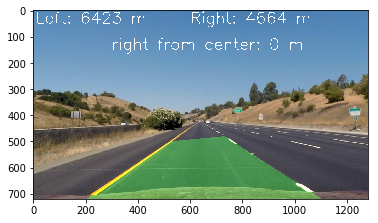

In [16]:
import math


def AddCarLocation(image, left_fit, right_fit):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    undist =image
    car_center = undist.shape[1]/2
    y_max = undist.shape[0]

    left_lane = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
    right_lane = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
    lane_center = (left_lane + right_lane)/2

    print(left_lane)
    print(right_lane)
    print(car_center)
    print(lane_center)

    location = ''
    difference = lane_center - car_center
    if difference > 0:
        location = 'left'
    else:
        location = 'right'

    distance = math.fabs(difference*xm_per_pix)
    print(distance)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, '{} from center: {:.0f} m'.format(location, distance), (300,150), font, 2,(255,255,255),2)
    return result

result = AddCarLocation(result, left_fit, right_fit)
plt.imshow(result)

## Pipeline for video

5015.317849587374 m 5421.342197844695 m
166.6219762594876
1137.291758247025
640.0
651.9568672532563
0.06320058405292611


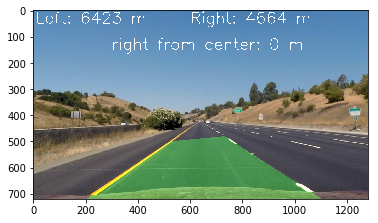

In [17]:
def pipeline(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    HLS_image = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s_channel_img = HLS_image[:,:,2]
    combined = np.zeros_like(s_channel_img)
    gradx = abs_sobel_thresh(s_channel_img,  orient='x', thresh_min=10, thresh_max=160)
    grady = abs_sobel_thresh(s_channel_img,  orient='y', thresh_min=10, thresh_max=160)
    mag_binary = mag_thresh(s_channel_img, sobel_kernel=3, mag_thresh=(10, 150))
    dir_binary = dir_threshold(s_channel_img, sobel_kernel=15, thresh=(0.7, 1.3))
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1 
    binary_warped_image = warp_image(combined)
    left_fit, right_fit = FindLanes(binary_warped_image)
    left_fitx, right_fitx, ploty = GetLanePoints(left_fit, right_fit, binary_warped_image)
    result = ProjectLanesOnImage(undist, binary_warped_image, left_fitx, right_fitx, ploty)
    result = AddLaneRadiusDetailsOnImage(result, left_fitx, right_fitx, ploty)
    result = AddCarLocation(result, left_fit, right_fit)
    return result

image = mpimg.imread(os.path.join('./test_images', 'straight_lines2.jpg'))
result = pipeline(image)
plt.imshow(result)